# Project Proposal: Exploring Pulsar Star Data

##### Madison Gill, Katie Le, Brooke MacLeod, Nandini Soni

## Introduction


#### Background
    
Pulsar stars are a type of Neutron star that produce radio emission that can be detected on Earth. Pulsar stars are significant as they are used as probes of space-time, the interstellar medium, and states of matter<sup>1</sup>. They are difficult to detect and identify as each individual pulsar star emits a slightly different emission pattern,  as measured by the star's Integrated Pulse Profile (IPP) <sup>5</sup>.

Light emitted by a pulsar contains information about the physics of Neutron stars, which are the densest material in the universe<sup>2</sup>. The precise blink or pulse  of a pulsar star can indicate a possible event happening in space. Cosmic distances can be calculated due to the regular periodicity of pulsar stars' light emissions and they have been used to test parts of the theory of relativity.

#### Research Question
    
---
<p style="text-align: center;"><b>How accurately can the Integrated Pulse Profile determine if a star is pulsar or non-pulsar?</b> </p>

---
    


#### About The Dataset

To answer the research question, the Pulsar Dataset [HTRU2](https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2) will be used with data collected through the High Time Resolution Universe Survey.  

<p>The dataset uses the mean, standard deviation, excess kurtosis, and skewness of the stars’ IPP and DM-SNR curves.</p>
    
><u>DM-SNR curves:</u>
>Measure the radio waves released by pulsar stars once they reach Earth and have already traveled long distances in space surrounded by free electrons<sup>3</sup>.

><u>Integrated Pulse Profile</u>: 
>Fingerprint of the pulsar. Averaging over thousands of rotations makes the profiles stable<sup>3</sup>.

><u> Excess Kurtosis</u>:
>Distribution of event outcomes have many outliers leading to fat tails on the bell-shaped distribution curve<sup>4</sup>. 
   

## Methods

The target variable for the planned analysis is the Class variable, and four predictor variables will be used. Since the IPP alone can determine whether a star is pulsar or non-pulsar, columns related to the DM-SNR curve will be excluded through selecting the mean, standard deviation, kurtosis, and skewness of the IPP.

To ensure the model can be tested, class imbalance was adjusted and the variables were standardized. The dataset was split into a training and testing set, with 75% of the data used for training and 25% for testing. Below, a classification model, using tuning and cross-validation, will be created using the $K$ nearest neighbors algorithm to predict the star type.

The results will be visualized by plotting estimated accuracy against number of neighbors to show the ideal $K$ value to use. 

In [1]:
#1. Download libraries

library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#2.Read in data Pulsar Star Data

pulsar_star_data<-read_csv("https://raw.githubusercontent.com/madisongill/dsci-100-2023s-group-39-section-002/main/HTRU_2.csv",col_names=FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#3. Tidy data (add column names,condense if needed)(unbalanced unsplit)

pulsar <- pulsar_star_data|>
rename(mean=X1,
       std_dev=X2,
       kurt=X3,
       skew=X4,
       mean_dmsnr=X5,
       std_dev_dmsnr=X6,
       kurt_dmsnr=X7,
       skew_dmsnr=X8,
       class=X9) |>
mutate(class = as_factor(class)) |>
select(mean, std_dev, kurt, skew, class)

<p>The Class variable has been converted to a factor because the corresponding observations are binary: pulsar or non-pulsar.</p>

### Class Imbalance

An issue that was identified was that the non-pulsar label was much more common than the pulsar label, which has been indicated by Table 1 and Figure 1. Since classifiers like the $K$-nn algorithm use the labels of nearby points to predict the label of a new point, if there is significantly more data points with the non-pulsar label, the algorithm will be more likely to pick that label. 
The data was balanced by taking a random sample of 1223 observations of each class from the pulsar data set as there were only 1223 pulsar labels present in the data set. The themis package could not be used to fix class imbalance due to its conflict with tidyverse. 

#### Table 1

In [4]:
class_count_unbalanced <- pulsar |> #summarize counts of class labels
    group_by(class) |>
    summarize(count = n())

class_count_unbalanced

class,count
<fct>,<int>
0,16259
1,1639


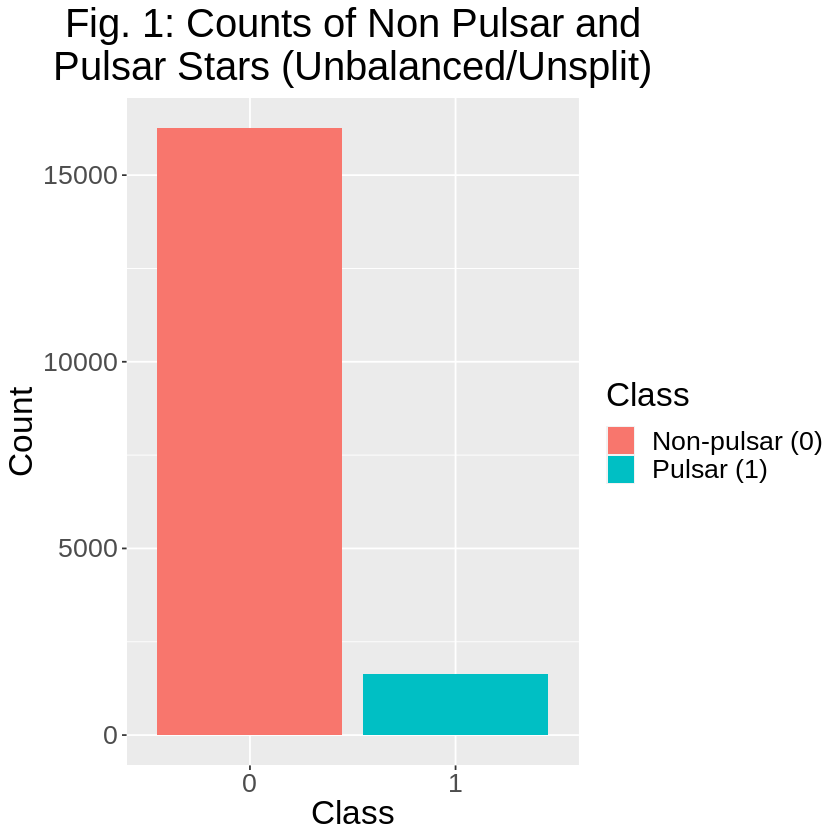

In [5]:
prop_plot <- class_count_unbalanced |> #bar graph to show proportions of classes (visual comparison)
    ggplot(aes(x = class, y = count, fill = class)) +
    geom_bar(stat = "identity") +
    labs(x = "Class", y = "Count", fill = "Class") +
    ggtitle("Fig. 1: Counts of Non Pulsar and\nPulsar Stars (Unbalanced/Unsplit)")+
    scale_fill_discrete(labels=c("Non-pulsar (0)", "Pulsar (1)")) +
    theme(text = element_text(size = 20)) +
    theme(plot.title = element_text(hjust = 0.5))

prop_plot

In [6]:
#4. Balanced the data set

pulsar_balanced <- pulsar |> 
    group_by(class) |>
    sample_n(1223)


In [16]:
#5.Split data into training and test set

#balanced, split
pulsar_split<-initial_split(pulsar_balanced,prop=0.75,strata=class)
pulsar_train<-training(pulsar_split)
pulsar_test<-testing(pulsar_split)

#demonstrate data was split
train<-nrow(pulsar_train)

split<-nrow(pulsar_balanced)

percentage_train_data<-train/split*100

test<-nrow(pulsar_test)

percentage_test_data<-test/split*100

### Summary

The following code cells summarize the data. The count and proportion of each Class, average and standard deviation of each variable, and a count of missing values are shown (of training data).

#### Table 2

In [8]:
number_obs<-nrow(pulsar_train)

class_count_balanced <- pulsar_train |> #summarize counts of class labels
    group_by(class) |>
    summarize(count = n(),
            percent_of_train=n()/number_obs*100) #percentage of pulsar vs non pulsar

missing_class_count <- as_tibble(sum(is.na(pulsar_train))) |> #checking for na values
    rename(missing_vals = value) |>
    bind_cols(class_count_balanced)  #combine class_count_balanced and missing values check into one

missing_class_count

missing_vals,class,count,percent_of_train
<int>,<fct>,<int>,<dbl>
0,0,917,50
0,1,917,50


#### Table 3

In [27]:
summary_train <- pulsar_train |> #the average of all the predictor variables
                mutate(mean_avg = mean(mean),
                    std_dev_avg= mean(std_dev),
                    kurt_avg = mean(kurt),
                    skew_avg = mean(skew))|>
                    slice(1) |>
                    select(class,mean_avg,std_dev_avg,kurt_avg,skew_avg)

summary_train

class,mean_avg,std_dev_avg,kurt_avg,skew_avg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,115.73023,47.45628,0.2258427,0.3835513
1,56.08118,38.55779,3.1520124,15.6062298


#### Table 4

In [28]:
standard_dev <- pulsar_train |> #the standard deviation of all predictor variables
                    mutate(mean_sd = sd(mean),
                       std_dev_sd = sd(std_dev),
                       kurt_sd = sd(kurt),
                       skew_sd = sd(skew))|>
                    slice(1) |>
                    select(class, mean_sd,std_dev_sd,kurt_sd,skew_sd)

standard_dev

class,mean_sd,std_dev_sd,kurt_sd,skew_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,16.99685,6.512658,0.3327947,1.096507
1,29.50195,7.763284,1.8454149,13.700357


### Visualization

This plot is used to determine the relationship between excess kurtosis and mean as a part of the exploratory data analysis. It appears to be a strong, negative, non-linear relationship. 

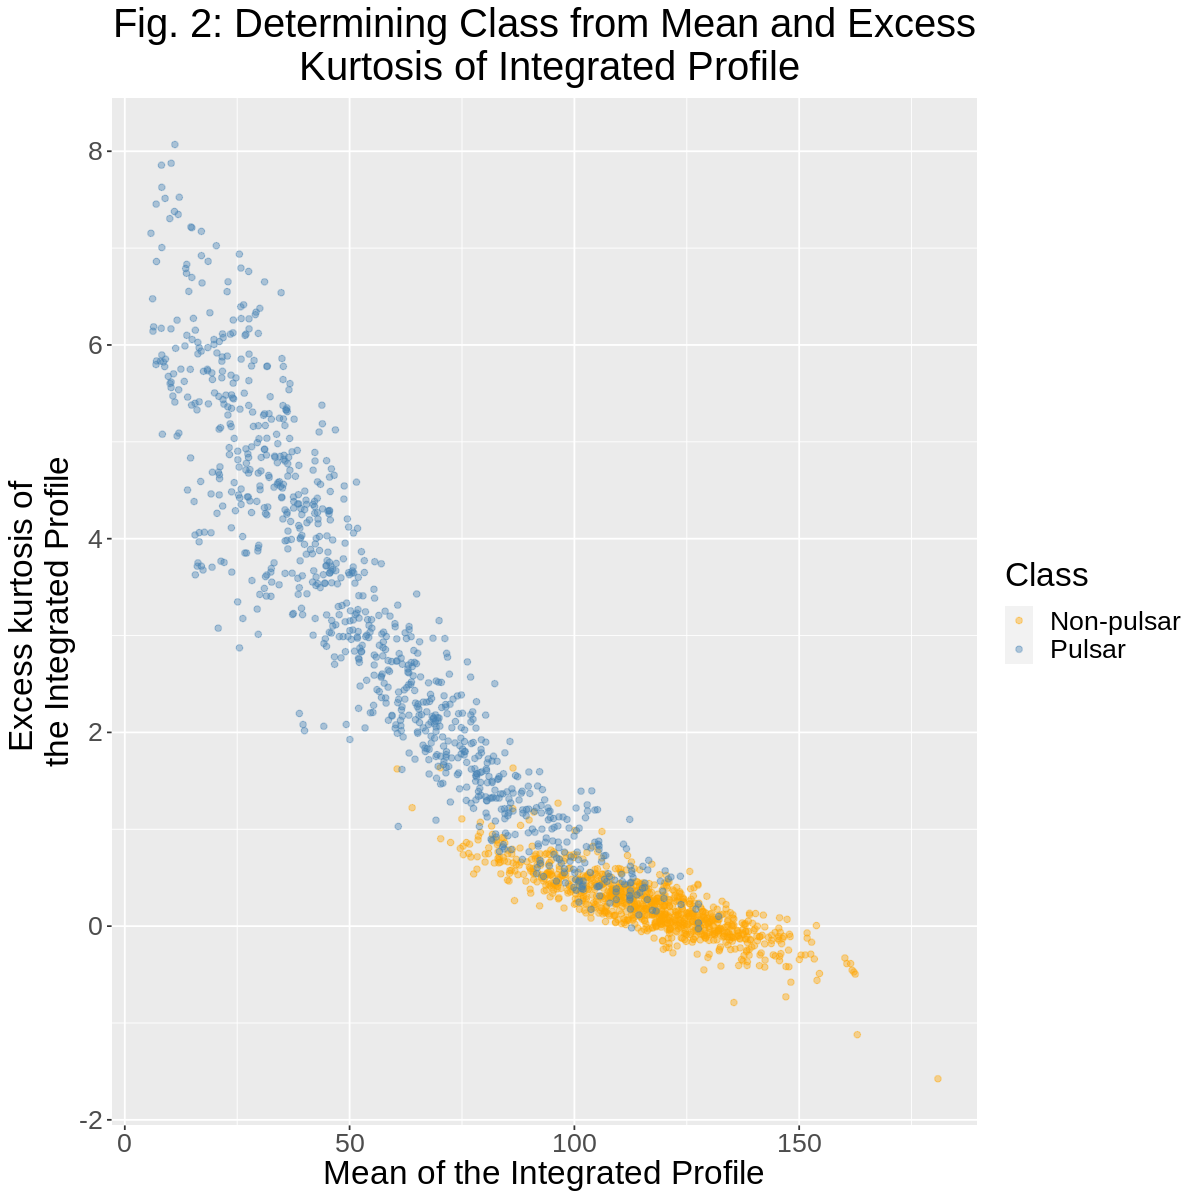

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)

pulsar_star_graph <- pulsar_train |>
ggplot(aes(x = mean, y = kurt, color = class)) +
geom_point(alpha = 0.4) +

labs(x = "Mean of the Integrated Profile", y = "Excess kurtosis of \nthe Integrated Profile", color = "Class") +
scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                   values = c("orange", "steel blue")) +
ggtitle("Fig. 2: Determining Class from Mean and Excess\n Kurtosis of Integrated Profile")+
theme(plot.title = element_text(hjust = 0.5))+
theme(text = element_text(size = 20))

pulsar_star_graph

Figure 2 graph shows the relationship between the mean and excess kurtosis of the Integrated Pulse Profile. The pulsar stars demonstrate more variability and diversity than the non-pulsar. 

### KNN Classification

A seed should be set before training the algorithm, as $K$-nn classification makes use of randomized processes, and setting a seed ensures reproducibility of the results that the model produces.  This seed should only be set once at the beginning of this analysis.


#### Tuning
Tuning is done during model specification to choose the best parameter, $K$, that will produce an accurate model. To reduce computational demand, a range of $K$ = 1-20 was chosen. 

#### Recipe
A recipe was created using all of the  predictor and target variables from the training data set. $K$ nearest neighbors is sensitive to the scale of the predictors, so in the pre-processing steps, all the predictor variables were standardized. This is to ensure that all data observation will be on a comparable scale and contribute equal shares to the calculation of the distance between points. All the standardized variables will have a standard deviation of 1 and mean of 0. 


#### Cross-Validation

In cross-validation, the overall training data is split into C evenly sized chunks in order to use many training and validation subsets to evaluate the accuracy of multiple $K$ values. One chunk is used as the validation set to evaluate the model's ability to correctly predict the Class on data it has not seen before and the remaining C−1 chunks are used as the training set. Here, C = 5 different chunks of the training set are used, resulting in 5 different choices for the validation set. C = 5 was chosen instead of C = 10 to reduce computational load. To add, cross-validation is used to evaluate the accuracy of multiple $K$ values. 

#### Workflow 

The recipe and model are combined in the workflow, which uses the `tune_grid()` function to fit the model based on each value of $K$ from 1 to 20, as specified by the `grid` argument.

#### Accuracy

Metrics are collected at the end so that an accuracy estimate can be viewed for each value of $K$ used. This information is then plotted.

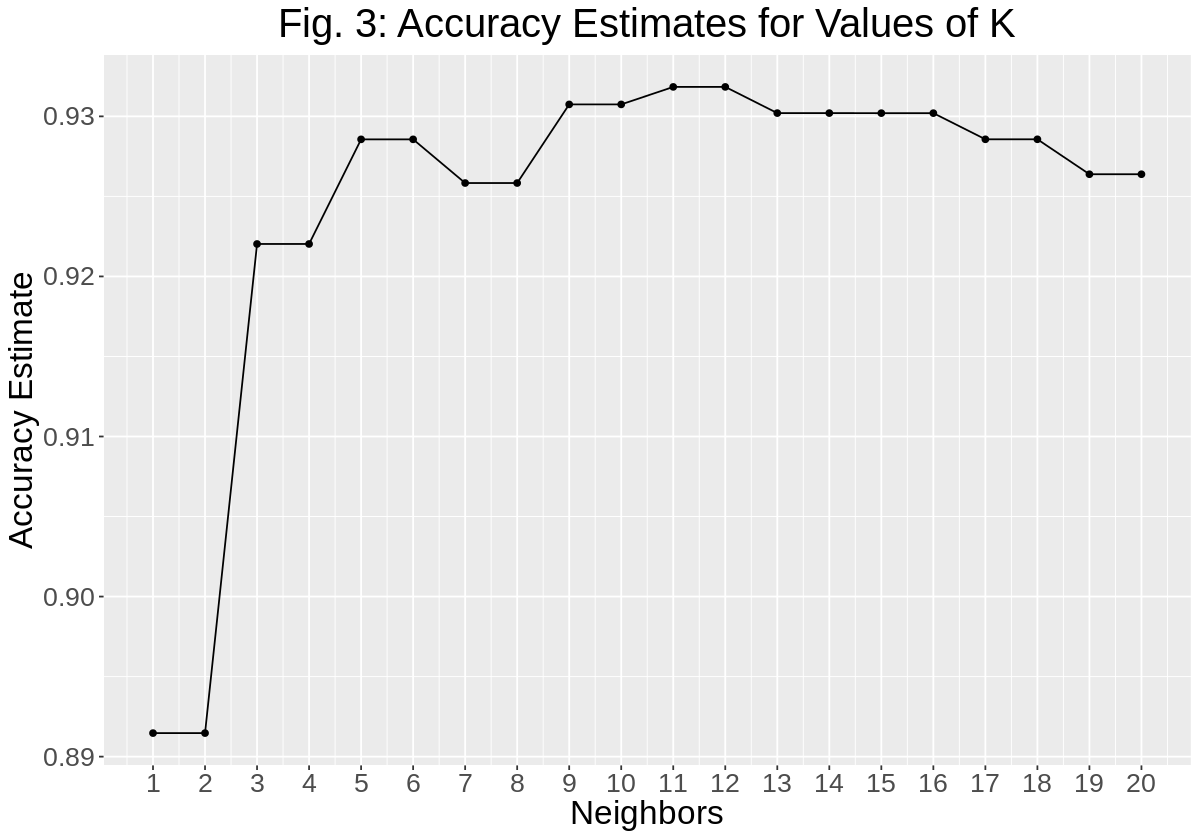

In [12]:
set.seed(1)

IPP_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

IPP_recipe <- recipe(class ~., data = pulsar_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())

IPP_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

IPP_results <- workflow() |>
                 add_recipe(IPP_recipe) |>
                 add_model(IPP_spec) |>
                 tune_grid(resamples = IPP_vfold, grid = tibble(neighbors = c(1:20))) |>
                 collect_metrics()

accuracies <- IPP_results |>
                 filter(.metric == 'accuracy')

options(repr.plot.width=10,repr.plot.height=7)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  ggtitle("Fig. 3: Accuracy Estimates for Values of K") +
                  theme(text = element_text(size = 20)) +
                  theme(plot.title = element_text(hjust = 0.5)) +
                  scale_x_continuous(breaks = 1:20)

cross_val_plot

After producing the plot for Figure 3, it was decided that the optimal $K$ value for the model is $K$ = 9 nearest neighbors.  Despite this plot  indicating that $K$ = 11 produced the highest accuracy in the initial training of the model, it ultimately resulted in a lower accuracy when used to predict labels on the test set (92.32%), while $K$ = 9 was higher (92.97%). Therefore, $K$ = 9 proved to be the better choice for the number of neighbors instead of $K$ = 11. Additionally, it is an odd number, preventing any ties when classifying an observation as pulsar or non-pulsar, and the computational demand of using $K$ = 9 is minimal. To summarize, $K$ = 9 is the most optimal value for the model to maximize its accuracy when predicting the class of a star based on IPP variables. 

After the optimal $K$ value is determined from the process above, everything is repeated for this specified number of neighbors, and the classifier predicts the classes for the test set that was set aside from the original data set. To check the accuracy, the metrics are gathered, as well as a confusion matrix to see a breakdown of what types of predictions the model made and where it went wrong. These are used to verify and further evaluate the efficacy of the model. 

In [13]:
IPP_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
       set_engine("kknn") |>
       set_mode("classification")

IPP_fit <- workflow() |>
             add_recipe(IPP_recipe) |>
             add_model(IPP_spec) |>
            fit(data = pulsar_train)
IPP_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06870229
Best kernel: rectangular
Best k: 9

#### Table 5

In [14]:
IPP_predictions <- predict(IPP_fit, pulsar_test) |>
                        bind_cols(pulsar_test)

IPP_metrics <- IPP_predictions |> metrics(truth = class, estimate = .pred_class) |>
                        filter(.metric == "accuracy")
 
IPP_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9297386


#### Table 6

In [15]:
IPP_conf_mat <- IPP_predictions |>
                        conf_mat(truth = class, estimate = .pred_class) 

IPP_conf_mat

          Truth
Prediction   0   1
         0 301  38
         1   5 268

## Discussion

The classification model for predicting pulsar and non-pulsar stars was found to have an accuracy of 92.97%. If the model were randomly guessing, the accuracy would have been about 50% since the data was evenly split to have an equal representation of both Classes. Therefore, it is clear that the model improved upon the majority classifier and is successfully extracting data from the predictor variables. This can also be seen in Table 6 which shows exactly how many Classes were correctly and incorrectly predicted from the test set.

The model is not 100% accurate, so it could be improved upon, but this accuracy is likely acceptable for the purpose of classifying stars. As identifying pulsar stars is outside the scope of this class, a definitive claim cannot be made as to whether the accuracy score obtained is acceptable. To truly understand what accuracy is considered acceptable, experts would need to be consulted in the field of astrophysics.


The expected outcome was to produce a highly accurate model which predicts the star's type, as Figure 2 shows that there is very little overlap between pulsar and non-pulsar stars; this means that they have clear differences and it should be easy to predict the class with a high accuracy. Based on the results, the model produced a high accuracy of 92.97% as expected based on the interpretation of Figure 2. If the high accuracy produced by the model is acceptable then this would mean only the IPP variables are important in identifying the stars, rather than the DM-SNR curve, which could have significant implications for identifying pulsar stars more efficiently and effectively in the future. This analysis can help with answering future questions such as: 


<p style="text-align: center;"><b>Which factors are effective predictors of star type?<b> </p>
<p style="text-align: center;"><b>Is this relationship between predictor variables applicable to other space phenomena?<b> </p>
<p style="text-align: center;"><b>Would using DM-SNR variables improve the model’s accuracy?<b> </p>
    




## References

1.https://archive.ics.uci.edu/dataset/372/htru2

2.https://www.space.com/32661-pulsars.html#:~:text=Pulsars%20have%20been%20used%20to,first%20time%20in%20February%202016

3.https://www.kaggle.com/datasets/charitarth/pulsar-dataset-htru2

4.https://www.investopedia.com/terms/e/excesskurtosis.asp#:~:text=Excess%20kurtosis%20means%20the%20distribution,by%20subtracting%20kurtosis%20by%20three.

5.https://www.sciencedirect.com/science/article/pii/S2213133720300585